In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 

from sklearn.impute import SimpleImputer
lr = 0.3
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix   
import math

from sklearn.model_selection import KFold
import shap
shap.initjs()

In [2]:
# loading the data
df =  pd.read_csv(r'C:\Users\Samuel Gbenga FALUYI\Downloads\heart.dat', sep=" ", header=None)

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


In [3]:
column_name = ['age', 'sex', 'chest pain', 'resting blood pressure', 'serum cholestoral', 'fasting blood sugar', 'resting electrocardiographic', 'maximum heart rate achieved',' exercise induced angina', 'oldpeak',' the slope of the peak exercise ST segment', 'number of major vessels', 'tha', 'label']

In [4]:
df.columns = column_name
df = df.fillna(0)
X = df.iloc[:, :-1]

In [5]:
y = df.iloc[:, -1]
y = y.map({1:0, 2:1})
y = y.map({0:0, 1:1, 2:1, 3:1, 4:1})
y = np.array(y)

In [6]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]

In [7]:
# Initializing the scaler for neural network input
scaler = StandardScaler()

In [8]:
# Number of folds for cross-validation
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [9]:
# Creating empty lists to store results
xgb_accuracies = []
nn_accuracies = []
ensemble_accuracies = []



In [10]:
# SHAP value storage (for the last fold for explanation purposes)
shap_values_xgb_total = []
shap_values_nn_total = []



In [11]:
fold_idx = 1

# Cross-validation loop
for train_index, test_index in kf.split(X):
    print(f"Fold {fold_idx}/{n_splits}")
    fold_idx += 1
    
   

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [12]:
 # Split data into train and test sets for the current fold
#X_train, X_test = X[train_index], X[test_index]
#y_train, y_test = y[train_index], y[test_index]

    # Split the dataset (ensure consistent split for both X and y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Scale the data for Neural Network
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# XGBoost model
import xgboost as xgb
from sklearn.metrics import accuracy_score
import tensorflow as tf
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
    
# XGBoost predictions and evaluation
xgb_preds = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_accuracies.append(xgb_accuracy)
    

In [15]:
 # Neural Network model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
nn_model = Sequential([
     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
     Dense(32, activation='relu'),
     Dense(1, activation='sigmoid')  
    ])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the neural network
nn_model.fit(X_train_scaled, y_train, epochs= 50, batch_size= 64, verbose=0)
    
    # Neural Network predictions and evaluation
nn_preds = nn_model.predict(X_test_scaled).round().astype(int).reshape(-1)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_accuracies.append(nn_accuracy)

C:\Users\Samuel Gbenga FALUYI\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [16]:
# Ensemble model using weighted average (can be modified to stacking)
ensemble_preds = (0.5 * xgb_preds + 0.5 * nn_preds).round()
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
ensemble_accuracies.append(ensemble_accuracy)


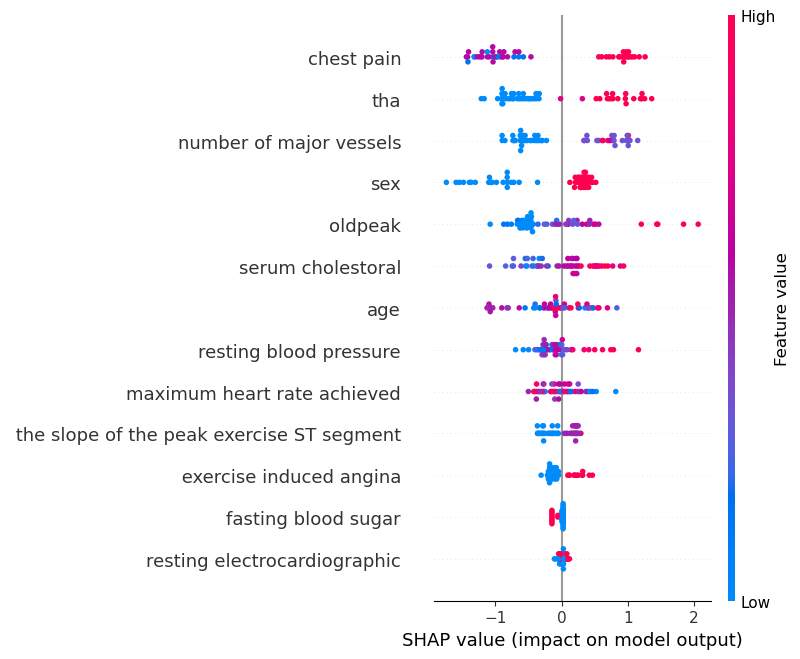

In [17]:
import shap

# Assuming 'X_test' is a DataFrame
# Create SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot for XGBoost, explicitly passing feature names from the DataFrame
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)



In [18]:
# Explainability: SHAP for XGBoost and Neural Network (only for the last fold, for simplicity)
if fold_idx == n_splits:
    explainer_xgb = shap.Explainer(xgb_model)
    shap_values_xgb = explainer_xgb(X_test)
    shap_values_xgb_total.append(shap_values_xgb)
        
    explainer_nn = shap.DeepExplainer(nn_model, X_train_scaled)
    shap_values_nn = explainer_nn.shap_values(X_test_scaled)
    shap_values_nn_total.append(shap_values_nn)
    
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}, Neural Network Accuracy: {nn_accuracy:.4f}, Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Calculate the mean accuracy across folds
print(f"\nMean XGBoost Accuracy: {np.mean(xgb_accuracies):.4f}")
print(f"Mean Neural Network Accuracy: {np.mean(nn_accuracies):.4f}")
print(f"Mean Ensemble Accuracy: {np.mean(ensemble_accuracies):.4f}")

XGBoost Accuracy: 0.8889, Neural Network Accuracy: 0.8889, Ensemble Accuracy: 0.8704

Mean XGBoost Accuracy: 0.8889
Mean Neural Network Accuracy: 0.8889
Mean Ensemble Accuracy: 0.8704


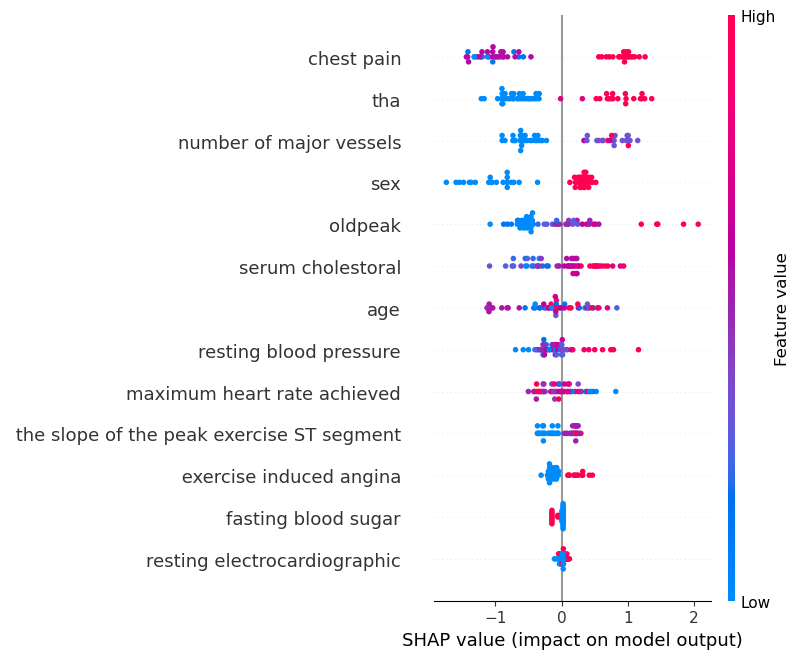

In [19]:
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)


C:\Users\Samuel Gbenga FALUYI\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


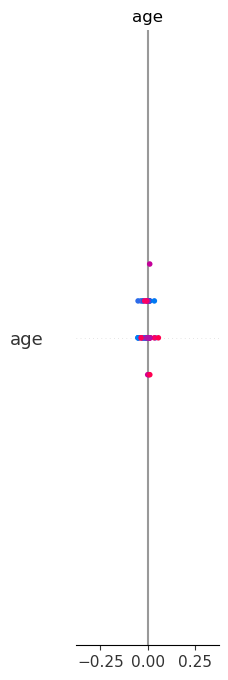

In [20]:
"""# Convert scaled test data to DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=)

# SHAP summary plot for Neural Network in the last fold
shap.summary_plot(shap_values_nn_total[0], X_test_scaled_df)
"""


# Create SHAP explainer for Neural Network
explainer_nn = shap.DeepExplainer(nn_model, X_train_scaled)
shap_values_nn = explainer_nn.shap_values(X_test_scaled)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test_scaled, feature_names = X_test.columns)



In [24]:
shap.plots.force(shap_values_xgb, X_test, feature_names=X_test.columns)

In [23]:
from alibi.explainers import AnchorTabular
from sklearn.preprocessing import StandardScaler

# Prepare explainer (using scaled data)
explainer_anchor = AnchorTabular(predict_fn = xgb_preds, feature_names = X_test.columns)
explainer_anchor.fit(X_train)

# Explain instance
exp = explainer_anchor.explain(X_test[0])
print('Anchor: %s' % (' AND '.join(exp.anchor)))
print('Precision: %.2f' % exp.precision)


PredictorCallError: Predictor failed to be called on <class 'numpy.ndarray'> of shape (1, 13) and dtype float32. Check that the parameter `feature_names` is correctly specified.